# Evaluate the annual estimates of modeled Arctic Passages Transports
This notebook compares the annual means for the freshwater flux, heat flux, and volume transport through the Arctic gateways using the following CM4 simulations:
1. CMIP6-CM4
2. Odiv-200
3. Odiv-209

Transports and fluxes are calculated using the definitions from from Woodgate et al. 2018. Model transport, $T_{vol}$, is the sum of the mass transport, $(umo,vmo)$, divided by the reference density, $\rho_0$. 

The freshwater flux, $T_{FW}$ is calculated as follows:
$$T_{FW} = T_{vol} \left( 1 - \frac{S}{S_{ref}} \right)$$ where $S_{ref} = 34.8$ psu.

Heat fluxes, $T_{Heat}$, are calculated as follows:
$$T_{Heat} = \rho T_{vol} c_w \left( \theta - \theta_{ref} \right)$$ where $\theta_{ref} = -1.9^\circ C$, $\rho = 1023$ kg m$^{-3}$ ; and $c_w = 3900$ J(kg K)$^{-1}$.

Transports and fluxes are calculated at each grid point and then intergrated across Bering Strait's cross-sectional area.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
import cmocean

## Set paths

In [3]:
## CMIP6 CM4
# base
base_cmip6 = '/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'
# pi
cmip6_PI = base_cmip6 + 'CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/'

In [4]:
# base for high res experiments
base_hres = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/'
## ODiv 209
# 1/8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv209_PI = base_hres + 'CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/'
## ODiv 210
# 1/4 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv210_PI = base_hres + 'CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/'

## Load and preprocess datasets

In [5]:
def open_model_data(flist):
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=['average_DT', 'average_T1', 'average_T2'])
    # Clean up coordinate names
    crds2chng = [match for match in list(DS.coords) if "_sub01" in match]
    for i in crds2chng:
        DS = DS.rename_dims({i:i[:2]}).rename({i:i[:2]})
    
    # Clean up variables with duplicate coords
    if "xh_sub02" in list(DS.coords):
        DS = DS.assign_coords(xh=("xh_sub02", DS.xh)).swap_dims({"xh_sub02": "xh"})
        DS = DS.drop_vars('xh_sub02')
    
    # Deal with padded zeros in xh
    if 'xh' in list(DS.coords):
        DS = DS.where(DS.xh!=0,drop=True)
    
    return DS.squeeze()

def preproc_data(path, pp):
    # Get pp output dir
    pp_dir = path + pp + '/ts/daily/*yr/'
    # gateway file list
    flist = glob(f'{pp_dir}*.nc')
    
    # open the data and clean up
    DS = open_model_data(flist)
    
    # open the static file
    OS = xr.open_dataset(path + pp + '/' + pp + '.static.nc',
                         engine='netcdf4')
    
    # assign geolat and geolon from ocean static
    DS = DS.assign_coords({'geolon':OS['geolon'].sel(xh=DS.xh,yh=DS.yh),
                           'geolat':OS['geolat'].sel(xh=DS.xh,yh=DS.yh)})
    
    if 'vo' in list(DS.keys()):
        DS = DS.assign_coords({'geolon_v':OS['geolon_v'].sel(xh=DS.xh,yq=DS.yq),
                               'geolat_v':OS['geolat_v'].sel(xh=DS.xh,yq=DS.yq)})
    
    if 'uo' in list(DS.keys()):
        DS = DS.assign_coords({'geolon_u':OS['geolon_u'].sel(xq=DS.xq,yh=DS.yh),
                               'geolat_u':OS['geolat_u'].sel(xq=DS.xq,yh=DS.yh)})
    
    return DS

In [6]:
# gateways
pps = ['ocean_Bering_Strait', 'ocean_Davis_Strait', 
       'ocean_Fram_Strait', 'ocean_Barents_opening']

### O-Div 209

In [7]:
BS_o209 = preproc_data(odiv209_PI,pps[0]).chunk({'time':24000})

In [8]:
DS_o209 = preproc_data(odiv209_PI,pps[1]).chunk({'time':7500})

In [9]:
FS_o209 = preproc_data(odiv209_PI,pps[2]).chunk({'time':4000})

In [10]:
BO_o209 = preproc_data(odiv209_PI,pps[3]).chunk({'time':2000})

### O-Div 210

In [11]:
BS_o210 = preproc_data(odiv210_PI,pps[0]).chunk({'time':48000})

In [12]:
DS_o210 = preproc_data(odiv210_PI,pps[1]).chunk({'time':15000})

In [13]:
FS_o210 = preproc_data(odiv210_PI,pps[2]).chunk({'time':8000})

In [14]:
BO_o210 = preproc_data(odiv210_PI,pps[3]).chunk({'time':4000})

### CMIP6 CM4

In [ ]:
BS_cm4 = preproc_data(cmip6_PI,pps[0]).chunk({'time':48000})

In [19]:
DS_cm4 = preproc_data(cmip6_PI,pps[1]).chunk({'time':15000})

In [20]:
FS_cm4 = preproc_data(cmip6_PI,pps[2]).chunk({'time':8000})

In [ ]:
BO_cm4 = preproc_data(cmip6_PI,pps[3]).chunk({'time':4000})

## Set up DASK cluster
In dask labextension, create a +NEW cluster. Click the < > widget, scale it to 16 workers and let's go!

## Define transport and flux calcs

In [ ]:
def calc_daily_transports(DS):
    # Model reference density [kg/m3]
    rho_0 = 1035
    # Reference potential temperature for heat flux [deg C]
    if 'Bering' in DS.attrs['filename']:
        theta_ref = -1.9
    else:
        theta_ref = -0.1
    # Heat capacity of water for model output [J/kg K]
    C_p = 3992
    # Reference salinity for freshwater flux [PSU]
    if 'Bering' in DS.attrs['filename']:
        S_ref = 34.8
    elif 'Barents' in DS.attrs['filename']:
        S_ref = 35.0
    
    # Find correct mass transport
    mo2use = [match for match in list(DS.keys()) if "mo" in match][0]
    
    # Volume transport [m3/s]
    DS['T_vol'] = DS[mo2use]/rho_0
    
    # Heat flux [W]
    DS['F_heat'] = rho_0 * DS.T_vol * C_p * (DS.thetao - theta_ref)
    
    # Heat transport [J]
    DS['T_heat'] = DS.F_heat * 86400
    
    # Freshwater flux [km3/s]
    DS['F_fresh'] = DS.T_vol * (1 - (DS.so/S_ref)) * (10**-9)
    
    # Fresh water transport [km3]
    DS['T_fresh'] = DS.F_fresh * 86400
    return DS

def integrate_transports(DS):
    # Find correct dimension for summing
    xy2use = [match for match in list(DS.T_vol.dims) if "h" in match][0]
    
     # Volume transport [Sv]
    DS['T_Ivol'] = (DS.T_vol.sum(dim=['z_l',xy2use])*(10**-6)).chunk({'time':-1})
    
    # Heat transport [EJ]
    DS['T_Iheat'] = (DS.T_heat.sum(dim=['z_l',xy2use])*(10**-18)).chunk({'time':-1})
    
    # Heat flux [TW]
    DS['F_Iheat'] = (DS.F_heat.sum(dim=['z_l',xy2use])*(10**-12)).chunk({'time':-1})
    
    # Fresh water transport [km3]
    DS['T_Ifresh'] = (DS.T_fresh.sum(dim=['z_l',xy2use])).chunk({'time':-1})
    
    # Fresh water flux [mSv]
    DS['T_Ifresh'] = (DS.T_fresh.sum(dim=['z_l',xy2use])*(10**-3)).chunk({'time':-1})
    return DS

## Calc volume transport, heat flux, and freshwater flux

### ODiv 209

In [64]:
BS_o209 = calc_daily_transports(BS_o209)
DS_o209 = calc_daily_transports(DS_o209)
FS_o209 = calc_daily_transports(FS_o209)
BO_o209 = calc_daily_transports(BO_o209)

In [65]:
BS_o209 = integrate_transports(BS_o209)
DS_o209 = integrate_transports(DS_o209)
FS_o209 = integrate_transports(FS_o209)
BO_o209 = integrate_transports(BO_o209)

### ODiv 210

In [67]:
BS_o210 = calc_daily_transports(BS_o210)
DS_o210 = calc_daily_transports(DS_o210)
FS_o210 = calc_daily_transports(FS_o210)
BO_o210 = calc_daily_transports(BO_o210)

In [68]:
BS_o210 = integrate_transports(BS_o210)
DS_o210 = integrate_transports(DS_o210)
FS_o210 = integrate_transports(FS_o210)
BO_o210 = integrate_transports(BO_o210)

### CMIP6 CM4

In [ ]:
BS_cm4 = calc_daily_transports(BS_cm4)
DS_cm4 = calc_daily_transports(DS_cm4)
FS_cm4 = calc_daily_transports(FS_cm4)
BO_cm4 = calc_daily_transports(BO_cm4)

In [ ]:
BS_cm4 = integrate_transports(BS_cm4)
DS_cm4 = integrate_transports(DS_cm4)
FS_cm4 = integrate_transports(FS_cm4)
BO_cm4 = integrate_transports(BO_cm4)

## Observational Estimates

### Bering Strait

In [ ]:
Tv_BS_obs = [0.8, 1.0, 0.6]
Fh_BS_obs = [15, 20, 10]
Ff_BS_obs = []

### Davis Strait

In [ ]:
Tv_DS_obs = [-2.6, -1.6, -3.6]
Th_DS_obs = []
Tf_DS_obs = []

### Fram Strait

In [ ]:
Tv_FS_obs = [-2.0, 0.7, -4.7]
Th_FS_obs = []
Tf_FS_obs = []

### Barents Opening

In [ ]:
Tv_BO_obs = [2.0, 3.9, 0.1]
Th_BO_obs = []
Tf_BO_obs = []

## Plot PI runs

### Berring Strait

In [74]:
Tv_BS_o209 = BS_o209['T_Ivol'].groupby('time.year').mean().chunk({'year':-1}).rolling(year=10,center=True).mean()
Th_BS_o209 = BS_o209['T_Iheat'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()
Tf_BS_o209 = BS_o209['T_Ifresh'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()

In [75]:
Tv_BS_o210 = BS_o210['T_Ivol'].groupby('time.year').mean().chunk({'year':-1}).rolling(year=10,center=True).mean()
Th_BS_o210 = BS_o210['T_Iheat'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()
Tf_BS_o210 = BS_o210['T_Ifresh'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()

In [ ]:
Tv_BS_cm4 = BS_cm4['T_Ivol'].groupby('time.year').mean().chunk({'year':-1}).rolling(year=10,center=True).mean()
Th_BS_cm4 = BS_cm4['T_Iheat'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()
Tf_BS_cm4 = BS_cm4['T_Ifresh'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()

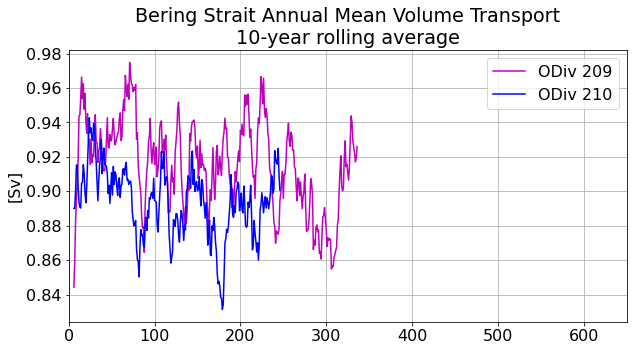

In [76]:
# Volume transport
fig = plt.figure(figsize=(10,5))
plt.plot(Tv_BS_cm4.year,Tv_BS_cm4,'k',label = 'CM4')
plt.plot(Tv_BS_o209.year,Tv_BS_o209,'m',label = 'ODiv 209')
plt.plot(Tv_BS_o210.year,Tv_BS_o210,'b',label = 'ODiv 210')
plt.fill_between([0, 650],[Tv_BS_obs[2], Tv_BS_obs[2]],[Tv_BS_obs[1], Tv_BS_obs[1]],
                 color='grey',alpha=0.3)
plt.plot([0, 650],[Tv_BS_obs[0], Tv_BS_obs[0]],'grey',label = 'Obs')
plt.title('Bering Strait Annual Mean Volume Transport\n10-year rolling average')
plt.ylabel('[Sv]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Tvol_BeringStrait_annual_PI.pdf')

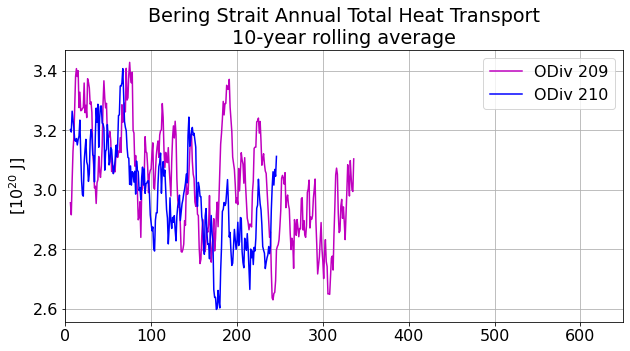

In [98]:
# Heat transport
fig = plt.figure(figsize=(10,5))
plt.plot(Th_BS_cm4.year,Th_BS_cm4,'k',label = 'CM4')
plt.plot(Th_BS_o209.year,Th_BS_o209,'m',label = 'ODiv 209')
plt.plot(Th_BS_o210.year,Th_BS_o210,'b',label = 'ODiv 210')
plt.title('Bering Strait Annual Total Heat Transport\n10-year rolling average')
plt.ylabel('[EJ]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Theat_BeringStrait_annual_PI.pdf')

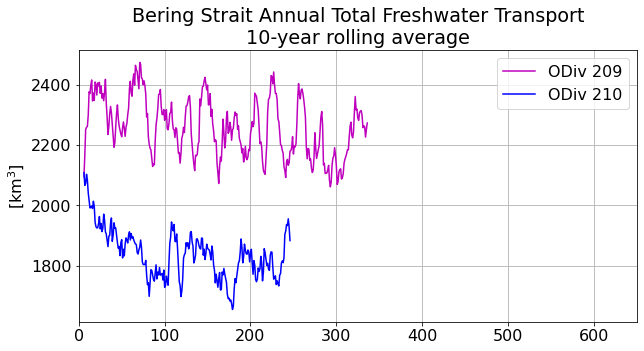

In [96]:
# Freshwater transport
fig = plt.figure(figsize=(10,5))
# plt.plot(Tv_BS_o209.year,T_cm4,'k',label = 'CM4')
plt.plot(Tf_BS_o209.year,Tf_BS_o209,'m',label = 'ODiv 209')
plt.plot(Tf_BS_o210.year,Tf_BS_o210,'b',label = 'ODiv 210')
plt.title('Bering Strait Annual Total Freshwater Transport\n10-year rolling average')
plt.ylabel('[km$^3$]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Tfresh_BeringStrait_annual_PI.pdf')

### Davis Strait

In [79]:
Tv_DS_o209 = DS_o209['T_Ivol'].groupby('time.year').mean().chunk({'year':-1}).rolling(year=10,center=True).mean()
Th_DS_o209 = DS_o209['T_Iheat'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()
Tf_DS_o209 = DS_o209['T_Ifresh'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()

In [80]:
Tv_DS_o210 = DS_o210['T_Ivol'].groupby('time.year').mean().chunk({'year':-1}).rolling(year=10,center=True).mean()
Th_DS_o210 = DS_o210['T_Iheat'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()
Tf_DS_o210 = DS_o210['T_Ifresh'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()

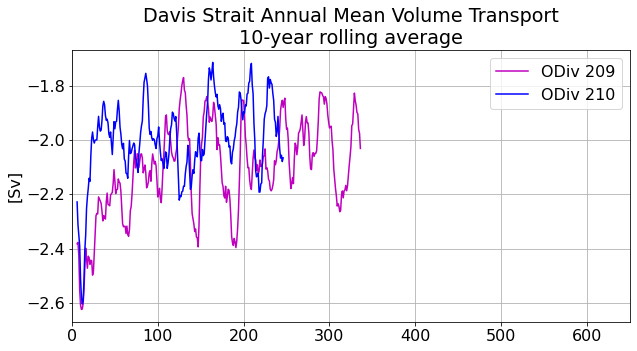

In [81]:
# Volume transport
fig = plt.figure(figsize=(10,5))
plt.plot(Tv_DS_cm4.year,Tv_DS_cm4,'k',label = 'CM4')
plt.plot(Tv_DS_o209.year,Tv_DS_o209,'m',label = 'ODiv 209')
plt.plot(Tv_DS_o210.year,Tv_DS_o210,'b',label = 'ODiv 210')
plt.fill_between([0, 650],[Tv_DS_obs[2], Tv_DS_obs[2]],[Tv_DS_obs[1], Tv_DS_obs[1]],
                 color='grey',alpha=0.3)
plt.plot([0, 650],[Tv_DS_obs[0], Tv_DS_obs[0]],'grey',label = 'Obs')
plt.title('Davis Strait Annual Mean Volume Transport\n10-year rolling average')
plt.ylabel('[Sv]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Tvol_DavisStrait_annual_PI.pdf')

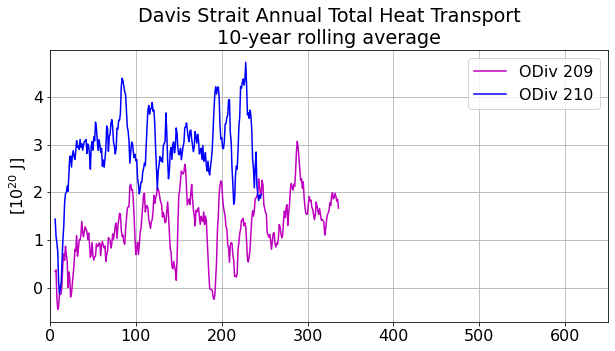

In [99]:
# Heat transport
fig = plt.figure(figsize=(10,5))
# plt.plot(Tv_BS_o209.year,T_cm4,'k',label = 'CM4')
plt.plot(Th_DS_o209.year,Th_DS_o209,'m',label = 'ODiv 209')
plt.plot(Th_DS_o210.year,Th_DS_o210,'b',label = 'ODiv 210')
plt.title('Davis Strait Annual Total Heat Transport\n10-year rolling average')
plt.ylabel('[$10^{20}$ J]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Theat_DavisStrait_annual_PI.pdf')

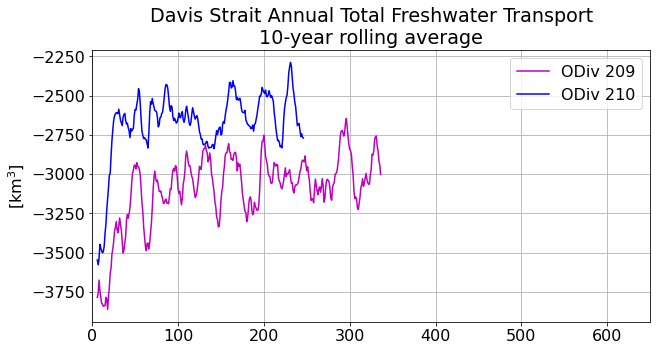

In [95]:
# Freshwater transport
fig = plt.figure(figsize=(10,5))
# plt.plot(Tv_BS_o209.year,T_cm4,'k',label = 'CM4')
plt.plot(Tf_DS_o209.year,Tf_DS_o209,'m',label = 'ODiv 209')
plt.plot(Tf_DS_o210.year,Tf_DS_o210,'b',label = 'ODiv 210')
plt.title('Davis Strait Annual Total Freshwater Transport\n10-year rolling average')
plt.ylabel('[km$^3$]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Tfresh_DavisStrait_annual_PI.pdf')

### Fram Strait

In [84]:
Tv_FS_o209 = FS_o209['T_Ivol'].groupby('time.year').mean().chunk({'year':-1}).rolling(year=10,center=True).mean()
Th_FS_o209 = FS_o209['T_Iheat'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()
Tf_FS_o209 = FS_o209['T_Ifresh'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()

In [85]:
Tv_FS_o210 = FS_o210['T_Ivol'].groupby('time.year').mean().chunk({'year':-1}).rolling(year=10,center=True).mean()
Th_FS_o210 = FS_o210['T_Iheat'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()
Tf_FS_o210 = FS_o210['T_Ifresh'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()

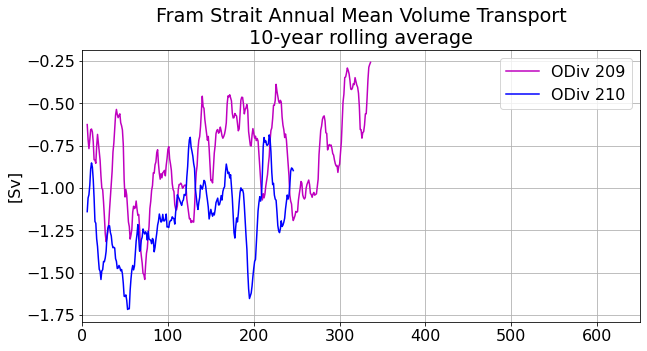

In [86]:
# Volume transport
fig = plt.figure(figsize=(10,5))
plt.plot(Tv_FS_cm4.year,Tv_FS_cm4,'k',label = 'CM4')
plt.plot(Tv_FS_o209.year,Tv_FS_o209,'m',label = 'ODiv 209')
plt.plot(Tv_FS_o210.year,Tv_FS_o210,'b',label = 'ODiv 210')
plt.fill_between([0, 650],[Tv_FS_obs[2], Tv_FS_obs[2]],[Tv_FS_obs[1], Tv_FS_obs[1]],
                 color='grey',alpha=0.3)
plt.plot([0, 650],[Tv_FS_obs[0], Tv_FS_obs[0]],'grey',label = 'Obs')
plt.title('Fram Strait Annual Mean Volume Transport\n10-year rolling average')
plt.ylabel('[Sv]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Tvol_FramStrait_annual_PI.pdf')

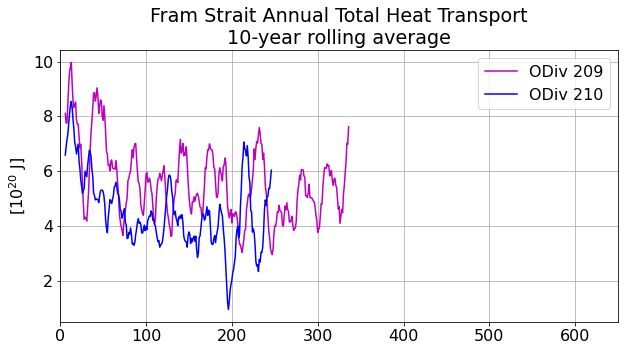

In [100]:
# Heat transport
fig = plt.figure(figsize=(10,5))
# plt.plot(Tv_BS_o209.year,T_cm4,'k',label = 'CM4')
plt.plot(Th_FS_o209.year,Th_FS_o209,'m',label = 'ODiv 209')
plt.plot(Th_FS_o210.year,Th_FS_o210,'b',label = 'ODiv 210')
plt.title('Fram Strait Annual Total Heat Transport\n10-year rolling average')
plt.ylabel('[$10^{20}$ J]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Theat_FramStrait_annual_PI.pdf')

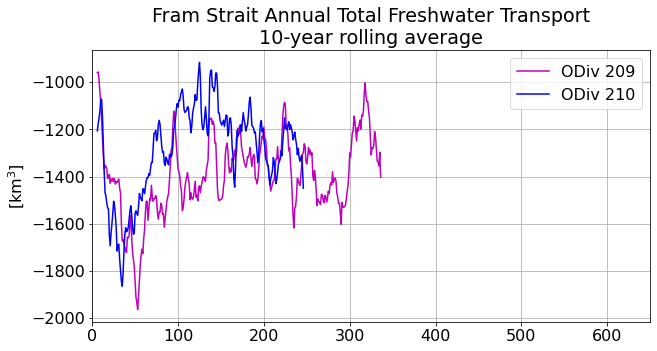

In [94]:
# Freshwater transport
fig = plt.figure(figsize=(10,5))
# plt.plot(Tv_BS_o209.year,T_cm4,'k',label = 'CM4')
plt.plot(Tf_FS_o209.year,Tf_FS_o209,'m',label = 'ODiv 209')
plt.plot(Tf_FS_o210.year,Tf_FS_o210,'b',label = 'ODiv 210')
plt.title('Fram Strait Annual Total Freshwater Transport\n10-year rolling average')
plt.ylabel('[km$^3$]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Tfresh_FramStrait_annual_PI.pdf')

### Barents Opening

In [89]:
Tv_BO_o209 = BO_o209['T_Ivol'].groupby('time.year').mean().chunk({'year':-1}).rolling(year=10,center=True).mean()
Th_BO_o209 = BO_o209['T_Iheat'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()
Tf_BO_o209 = BO_o209['T_Ifresh'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()

In [90]:
Tv_BO_o210 = BO_o210['T_Ivol'].groupby('time.year').mean().chunk({'year':-1}).rolling(year=10,center=True).mean()
Th_BO_o210 = BO_o210['T_Iheat'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()
Tf_BO_o210 = BO_o210['T_Ifresh'].groupby('time.year').sum().chunk({'year':-1}).rolling(year=10,center=True).mean()

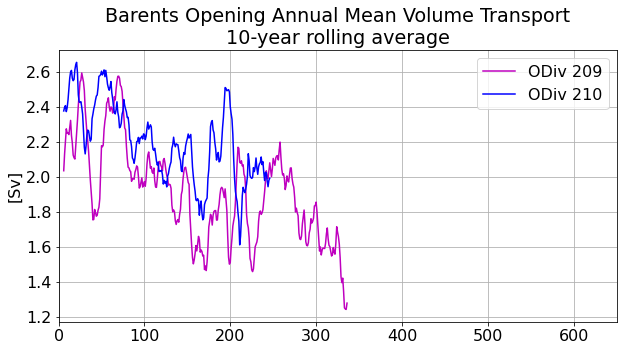

In [91]:
# Volume transport
fig = plt.figure(figsize=(10,5))
plt.plot(Tv_BO_cm4.year,Tv_BO_cm4,'k',label = 'CM4')
plt.plot(Tv_BO_o209.year,Tv_BO_o209,'m',label = 'ODiv 209')
plt.plot(Tv_BO_o210.year,Tv_BO_o210,'b',label = 'ODiv 210')
plt.fill_between([0, 650],[Tv_BO_obs[2], Tv_BO_obs[2]],[Tv_BO_obs[1], Tv_BO_obs[1]],
                 color='grey',alpha=0.3)
plt.plot([0, 650],[Tv_BO_obs[0], Tv_BO_obs[0]],'grey',label = 'Obs')
plt.title('Barents Opening Annual Mean Volume Transport\n10-year rolling average')
plt.ylabel('[Sv]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Tvol_BarentsOpening_annual_PI.pdf')

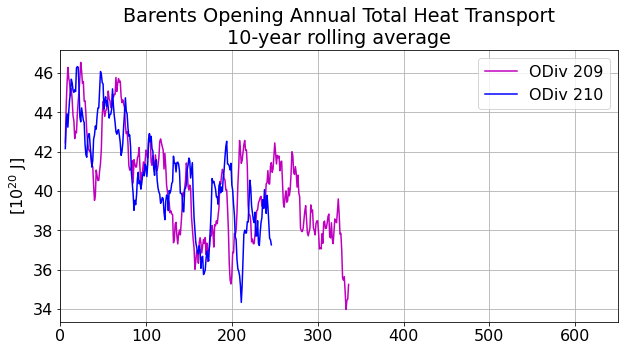

In [101]:
# Heat transport
fig = plt.figure(figsize=(10,5))
# plt.plot(Tv_BS_o209.year,T_cm4,'k',label = 'CM4')
plt.plot(Th_BO_o209.year,Th_BO_o209,'m',label = 'ODiv 209')
plt.plot(Th_BO_o210.year,Th_BO_o210,'b',label = 'ODiv 210')
plt.title('Barents Opening Annual Total Heat Transport\n10-year rolling average')
plt.ylabel('[$10^{20}$ J]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Theat_BarentsOpening_annual_PI.pdf')

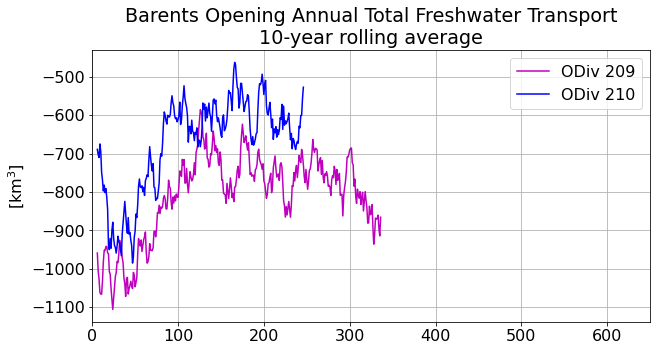

In [102]:
# Freshwater transport
fig = plt.figure(figsize=(10,5))
# plt.plot(Tv_BS_o209.year,T_cm4,'k',label = 'CM4')
plt.plot(Tf_BO_o209.year,Tf_BO_o209,'m',label = 'ODiv 209')
plt.plot(Tf_BO_o210.year,Tf_BO_o210,'b',label = 'ODiv 210')
plt.title('Barents Opening Annual Total Freshwater Transport\n10-year rolling average')
plt.ylabel('[km$^3$]')
plt.legend(loc='upper right')
plt.xlim(0,650)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/ArcticGateways/Tfresh_BarentsOpening_annual_PI.pdf')